<a href="https://colab.research.google.com/github/Felipanjos/a3_ia_2022.2/blob/main/Projeto_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [422]:
import pandas as pd
import numpy as np
import random
import string
import sklearn
from itertools import groupby

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as sts

In [394]:
df = pd.read_csv('chip_dataset.csv', index_col=[0])
df.drop('FP16 GFLOPS', axis=1, inplace=True)
df.drop('FP32 GFLOPS', axis=1, inplace=True)
df.drop('FP64 GFLOPS', axis=1, inplace=True)
vendors = list(np.unique(df['Vendor']))

In [396]:
num_attribs = list(df.describe().columns)
cat_attribs = ['Vendor']

### B. Divisão 

##### a) Amostragem estratificada em Conjunto de Treinamento e Conjunto de Teste

In [424]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [275]:
ranges = [0, df['Transistors (million)'].describe()['25%'], 500, 1000, 2000, 6000, 15000, 30000, np.inf]
tiers = ['F', 'E', 'D', 'C', 'B', 'A', 'S', 'S+']

df['Rank'] = pd.cut(df['Transistors (million)'], bins = ranges, labels = tiers)

In [276]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(df, df['Rank']):
  strat_train_set = df.loc[train_index]
  strat_test_set = df.loc[test_index]

In [277]:
def amostragem_estratificada(test_set):
    return (test_set['Rank'].value_counts() / len(test_set))*100    

In [278]:
amostragem_estratificada(strat_test_set)

F     24.963504
C     19.708029
B     17.226277
E     15.328467
D     14.598540
A      6.131387
S      1.751825
S+     0.291971
Name: Rank, dtype: float64

In [ ]:
strat_train_set.drop(columns=['Rank'], inplace=True)
strat_test_set.drop(columns=['Rank'], inplace=True)

### C. Exploração 

##### a) Visualização dos Dados com gráficos de dispersão e histograma

In [279]:
df['Release Date'] = pd.to_datetime(df['Release Date'])

In [ ]:
# ampliar escala 
strat_test_set['Transistors (million)'].hist()

In [ ]:
strat_train_set['Transistors (million)'].hist()

In [ ]:
df.plot(kind='scatter', x='Release Date', y='Transistors (million)')

##### b. Levantamento de hipóteses sobre as distribuições dos dados


##### c. Busca de correlações (Coeficientes de correlação)

In [286]:
df['Release Date'] = pd.to_numeric(df['Release Date'])

##### Basearemos a análise das valueelações na coluna Transistors (million), que é o nosso objeto de predição

In [326]:
num_attribs

['Process Size (nm)',
 'TDP (W)',
 'Die Size (mm^2)',
 'Transistors (million)',
 'Freq (MHz)']

In [335]:
for value in df.corr()['Transistors (million)']:
    print(value)

-0.002568951085001034
-0.3977453283926615
0.46970179480450375
0.6402633611101106
1.0
-0.04411544348939104


C:\Users\anjos\AppData\Local\Temp\ipykernel_10336\3423880030.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  for value in df.corr()['Transistors (million)']:


In [346]:
colunas_para_calculo = ['Release Date'] + num_attribs
print('Coeficiente de correlação de Pearson entre a coluna Transistors (million) e:')

coor_dict = {}
r_list = []

for value in df.corr()['Transistors (million)']:
    if value == 1:
        r = 'relação linear perfeita e positiva'
    elif value == 0:
        r = 'inexistência linear'
    elif value == -1:
        r = 'relação linear perfeita e negativa'
    elif value > 0:
        r = 'relação linear positiva'
    elif value < 0:
        r = 'relação linear negativa'

    r_list.append(r)

print(df.corr(method='pearson', min_periods=1)['Transistors (million)'], '\n')

count = 0
for col in colunas_para_calculo: 
    coor_dict[col] = r_list[count]
    print(f'{col}: {coor_dict[col]}')
    count += 1


Coeficiente de correlação de Pearson entre a coluna Transistors (million) e:
Release Date            -0.002569
Process Size (nm)       -0.397745
TDP (W)                  0.469702
Die Size (mm^2)          0.640263
Transistors (million)    1.000000
Freq (MHz)              -0.044115
Name: Transistors (million), dtype: float64 

Release Date: relação linear negativa
Process Size (nm): relação linear negativa
TDP (W): relação linear positiva
Die Size (mm^2): relação linear positiva
Transistors (million): relação linear perfeita e positiva
Freq (MHz): relação linear negativa


C:\Users\anjos\AppData\Local\Temp\ipykernel_10336\473720730.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  for value in df.corr()['Transistors (million)']:
C:\Users\anjos\AppData\Local\Temp\ipykernel_10336\473720730.py:21: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr(method='pearson', min_periods=1)['Transistors (million)'], '\n')


### D. Preparação

##### a) Selecionando 10% das colunas

In [397]:
qtd_colunas = len(df.columns)
p_colunas = round(qtd_colunas * 10 / 100)
coluna_aleatoria = df.sample(n=p_colunas, axis='columns').keys()[0]
colunas_numericas = df.describe().columns
colunas_categoricas = df.describe(exclude=np.number).columns
coluna_aleatoria # escolhendo uma coluna aleatoriamente

'Release Date'

##### a) Selecionando 3% dos dados

In [398]:
len(df)

4854

In [399]:
p_3 = round(df.shape[0] * 3 / 100)
p_3


146

##### a) Excluindo 3% dos dados aleatoriamente

In [403]:
df[coluna_aleatoria].info()

<class 'pandas.core.series.Series'>
Int64Index: 4854 entries, 0 to 4853
Series name: Release Date
Non-Null Count  Dtype 
--------------  ----- 
4854 non-null   object
dtypes: object(1)
memory usage: 75.8+ KB


In [404]:
reg_excluidos = df.sample(n=p_3)
reg_exc_index = reg_excluidos.index.array
df.loc[reg_exc_index, coluna_aleatoria] = np.nan

In [405]:
df[coluna_aleatoria].info()

<class 'pandas.core.series.Series'>
Int64Index: 4854 entries, 0 to 4853
Series name: Release Date
Non-Null Count  Dtype 
--------------  ----- 
4708 non-null   object
dtypes: object(1)
memory usage: 204.9+ KB


##### a) Alterando 3% dos dados aleatoriamente

In [367]:
def gerar_string_aleatoria():
  letters = string.ascii_lowercase
  return ''.join(random.choice(letters) for i in range(10)) 

def gerar_numero_aleatorio():
  return random.randint(0, 999)

In [391]:
# listando indexes que sofreram alteração na coluna aleatória
df_selecao_nao_nulo = df[~df[coluna_aleatoria].isnull()]
reg_alterados = df_selecao_nao_nulo.sample(n=p_3)
reg_alter_index = reg_alterados.index.array
list(reg_alter_index)

[4252,
 617,
 1458,
 3810,
 4314,
 3469,
 3410,
 3013,
 4017,
 3750,
 2414,
 279,
 4371,
 3400,
 764,
 1314,
 73,
 2001,
 2334,
 4329,
 4442,
 911,
 1379,
 161,
 3811,
 3417,
 1104,
 2590,
 1923,
 2745,
 1724,
 2243,
 4769,
 3104,
 3672,
 1865,
 3473,
 325,
 3479,
 4207,
 4552,
 2553,
 1888,
 598,
 2042,
 1165,
 575,
 2379,
 4012,
 3889,
 2101,
 1717,
 4062,
 1931,
 1472,
 4143,
 855,
 154,
 1279,
 3031,
 1670,
 1445,
 2873,
 4508,
 1523,
 1397,
 196,
 1601,
 2309,
 655,
 555,
 4480,
 938,
 1006,
 3560,
 3619,
 3066,
 1736,
 639,
 1628,
 1347,
 4340,
 3999,
 4689,
 3475,
 1972,
 3204,
 3775,
 1892,
 3856,
 4022,
 1121,
 465,
 888,
 1433,
 2936,
 866,
 684,
 4721,
 2630,
 2281,
 229,
 1752,
 3480,
 2969,
 647,
 1358,
 358,
 1716,
 658,
 2905,
 393,
 4336,
 846,
 3337,
 2291,
 3520,
 1485,
 1438,
 2237,
 2518,
 2093,
 3456,
 2133,
 4670,
 2626,
 3135,
 2825,
 1951,
 3492,
 3046,
 105,
 4088,
 2156,
 654,
 3302,
 471,
 403,
 2035,
 4463,
 1356,
 2078,
 3285,
 2134,
 4844,
 296]

In [379]:
if coluna_aleatoria in colunas_numericas:
    for index in reg_alter_index:
        df.loc[[index],[coluna_aleatoria]] = gerar_numero_aleatorio()
else:
    for index in reg_alter_index:
        df.loc[[index],[coluna_aleatoria]] = gerar_string_aleatoria()

In [389]:
# listando alterações
count = 0
for index in reg_alter_index:
    print(df[coluna_aleatoria][index])
    count += 1
    if count == 10:
        break

vkaznxlogg
iahdbjlews
ihbrtcamgs
wtvbzfgklr
gexcqnsoth
yduuxzowko
plxftdswrn
zaziillypd
gwsdkvzifb
cxeuefjvtv


#### b) Limpeza dos dados

i. Codificação One-Hot

In [406]:
encoder = OneHotEncoder()
onehot_encoded_df = pd.DataFrame(encoder.fit_transform(df[['Vendor']]).toarray())
onehot_encoded_df.columns = vendors

onehot_encoded_df = df.join(onehot_encoded_df)
onehot_encoded_df.drop('Vendor', axis=1, inplace=True)
onehot_encoded_df

,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,AMD,ATI,Intel,NVIDIA,Other
0,AMD Athlon 64 3500+,CPU,2007-02-20,65.0,45.0,77.0,122.0,2200.0,Unknown,1.0,0.0,0.0,0.0,0.0
1,AMD Athlon 200GE,CPU,2018-09-06,14.0,35.0,192.0,4800.0,3200.0,Unknown,1.0,0.0,0.0,0.0,0.0
2,Intel Core i5-1145G7,CPU,2020-09-02,10.0,28.0,NaN,NaN,2600.0,Intel,0.0,0.0,1.0,0.0,0.0
3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.0,80.0,160.0,1400.0,1800.0,Intel,0.0,0.0,1.0,0.0,0.0
4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.0,125.0,258.0,758.0,3700.0,Unknown,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849,NVIDIA Quadro 3000M,GPU,2011-02-22,40.0,75.0,332.0,1950.0,450.0,TSMC,0.0,0.0,0.0,1.0,0.0
4850,Intel GMA 950,GPU,2005-06-01,90.0,7.0,NaN,NaN,250.0,Intel,0.0,0.0,1.0,0.0,0.0
4851,NVIDIA GeForce GT 320M,GPU,2010-03-03,40.0,23.0,100.0,486.0,500.0,TSMC,0.0,0.0,0.0,1.0,0.0
4852,NVIDIA GeForce FX 5200,GPU,2003-03-06,150.0,NaN,65.0,29.0,250.0,TSMC,0.0,0.0,0.0,1.0,0.0


ii. Estratégia para dados numéricos ausentes - mediana geral

In [427]:
df.describe()

,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz)
count,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000
mean,53.123606,83.649683,200.246608,2150.965029,1510.590292
std,41.069586,77.860123,130.919148,4267.883640,1013.840038
min,7.000000,1.000000,1.000000,10.000000,100.000000
25%,28.000000,35.000000,111.000000,222.000000,650.000000
50%,40.000000,65.000000,160.000000,731.000000,1124.000000
75%,65.000000,100.000000,246.000000,2080.000000,2400.000000
max,250.000000,900.000000,826.000000,54200.000000,4700.000000


In [425]:
sts.median(df['Transistors (million)'])

731.0

C:\Users\anjos\AppData\Local\Temp\ipykernel_10336\3717774888.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df['Transistors (million)'])


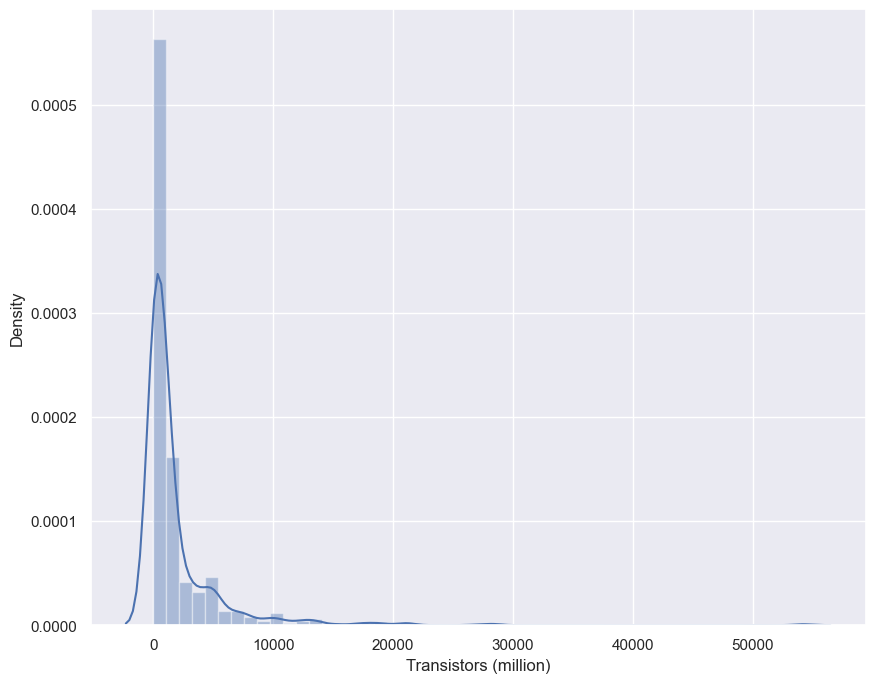

In [417]:
sns.set(rc={"figure.figsize": (10, 8)}); np.random.seed(0)
ax = sns.distplot(df['Transistors (million)'])
plt.show()

A atribuição da mediana geral foi utilizada para lidar com os valores nulos das colunas em que existiam, pelos seguintes motivos:


Utilizaremos a coluna 'Transistors (million)' como referência por acreditarmos que se trata da coluna principal do dataset.

*   A remoção dos valores nulos do conjunto levaria à retirada de 29.1% dos dados, pouco mais de 1/4 do dataset original
*   Pela forte presença de outliers no dataset, o uso da média para atribuição de dados ausentes não seria uma boa opção. A média da coluna 'Transistors (million)'     seria aproximadamente 2151 milhões.
*   O treinamento de um preditor geraria esforço adicional e sairia do foco da entrega, então utilizamos uma estratégia mais simples para tratar dessa questão.
*   Por isso, escolhemos o uso da mediana. Para a coluna 'Transistorts (millions)' a mediana é 731 milhões, praticamente 3 vezes menos do que a média. A partir disso, obtemos o valor central do dataset, que sofre menos com o impacto dos outliers.


iii. Escalonamento de características: Padronização e iv. Pipeline transformadora

In [ ]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),        
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat', OneHotEncoder(), cat_attribs),
    ])

In [ ]:
df_prepared = full_pipeline.fit_transform(df)

Utilizando a full_pipeline, aplicamos
*   Codificação One-Hot para dados categóricos com mais de duas categorias (escolhemos a coluna 'Vendor')
*   Atribuição da mediana geral para os dados numéricos ausentes
*   Escalonamento de caretísticas: Padronização
*   Pipeline transformadora utilizando codificaçõa one hot, atribuição de mediana e padronização
